In [1]:
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import scipy as sp
from scipy.sparse import coo_matrix
from argparse import ArgumentParser
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.utils import to_categorical, normalize
from sklearn.preprocessing import scale

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import pickle
import gzip
from pathlib import Path

# set seeds
from numpy.random import seed
seed(1)


In [2]:

def get_tsne_for_plotting(encodings):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
        tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g



In [3]:

# number of pseudobulks PER patient
n_train = 1000

### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
Label_full_same = Label_full
label_full_same = to_categorical(Label_full)
unlabeled_same_idx = 11


Label_full_sm2 = np.concatenate([np.full(n_train, 1), np.full(n_train, 2),
                    np.full(n_train, 3), np.full(n_train, 4)], axis=0)
Label_full = np.concatenate([Label_full, Label_full_sm2+11])
label_full = to_categorical(Label_full)

Label_full_dim = np.full(n_train*12, 0)
Label_full_sm2_dim = np.full(n_train*4, 1)
Label_full_dim = np.concatenate([Label_full_dim, Label_full_sm2_dim])
label_full_dim = to_categorical(Label_full_dim)

label_full_cross = label_full
label_full_cross_dim = label_full_dim

In [7]:
res_path = f"{os.getcwd()}/../../results/single_cell_data/diva_pbmc/"
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_pbmc/"
cs_res_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_pbmc/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train

exp_id = "pbmc_rep2_10xV2"
pbmc_rep2_10xV2_X, pbmc_rep2_10xV2_Y, pbmc_rep2_10xV2_gene_df = sc_preprocess.read_all_diva_files(data_path, range(10), exp_id)
pbmc_rep2_10xV2_X.columns = pbmc_rep2_10xV2_gene_df


lab_id = "pbmc68k"
unlab_id = "pbmc_rep2_10xV2"
pbmc68k_enc = tf.keras.models.load_model(f"{res_path}/{lab_id}_{unlab_id}_encoder")
pbmc68k_train = read_gene_file(res_path, f"{lab_id}-{unlab_id}")




In [8]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_train = np.where(np.logical_and(Label_full_same!=unlabeled_same_idx, Label_full_same!=0))[0]
idx_unlab = np.where(Label_full_same==unlabeled_same_idx)[0]

X_temp = pbmc_rep2_10xV2_X.reindex(columns=pbmc68k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp #[idx_train]
X_temp = scale(X_temp, axis=1)


Y_temp = pbmc_rep2_10xV2_Y
Y_temp = np.argmax(Y_temp.to_numpy(), axis=1)
Y_temp = Y_temp #[idx_train]

label_temp = Label_full_same #[idx_train][idx_train]


print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc68k_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


Number unique Y: 13


2022-03-08 20:04:27.456423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


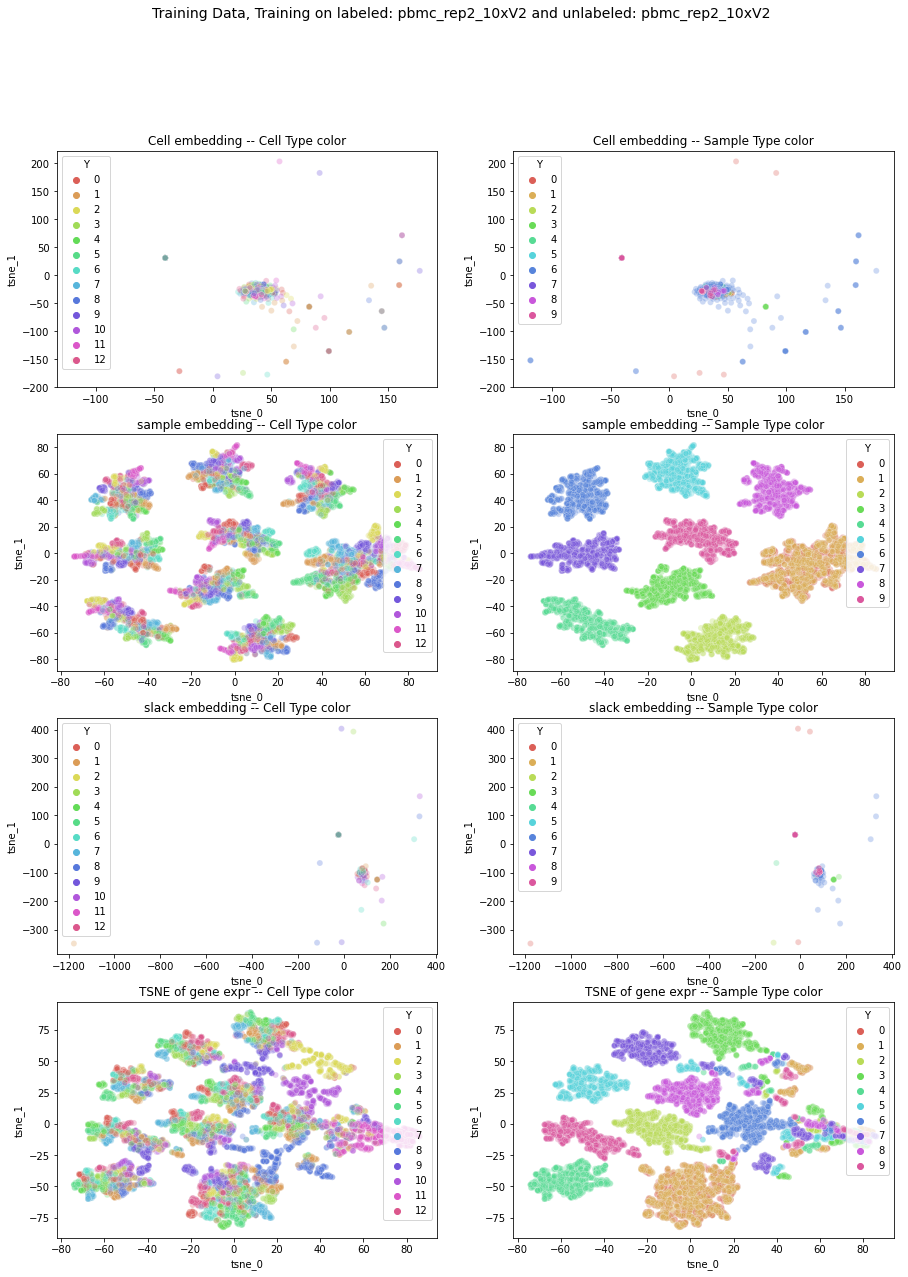

In [9]:


fig, axs = plt.subplots(4, 2, figsize=(15,20))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")



fig.suptitle("Training Data, Training on labeled: pbmc_rep2_10xV2 and unlabeled: pbmc_rep2_10xV2", fontsize=14)

fig.show()


Number unique Y: 13
(10000, 2)
(10000, 2)


ValueError: Length of values (6000) does not match length of index (10000)

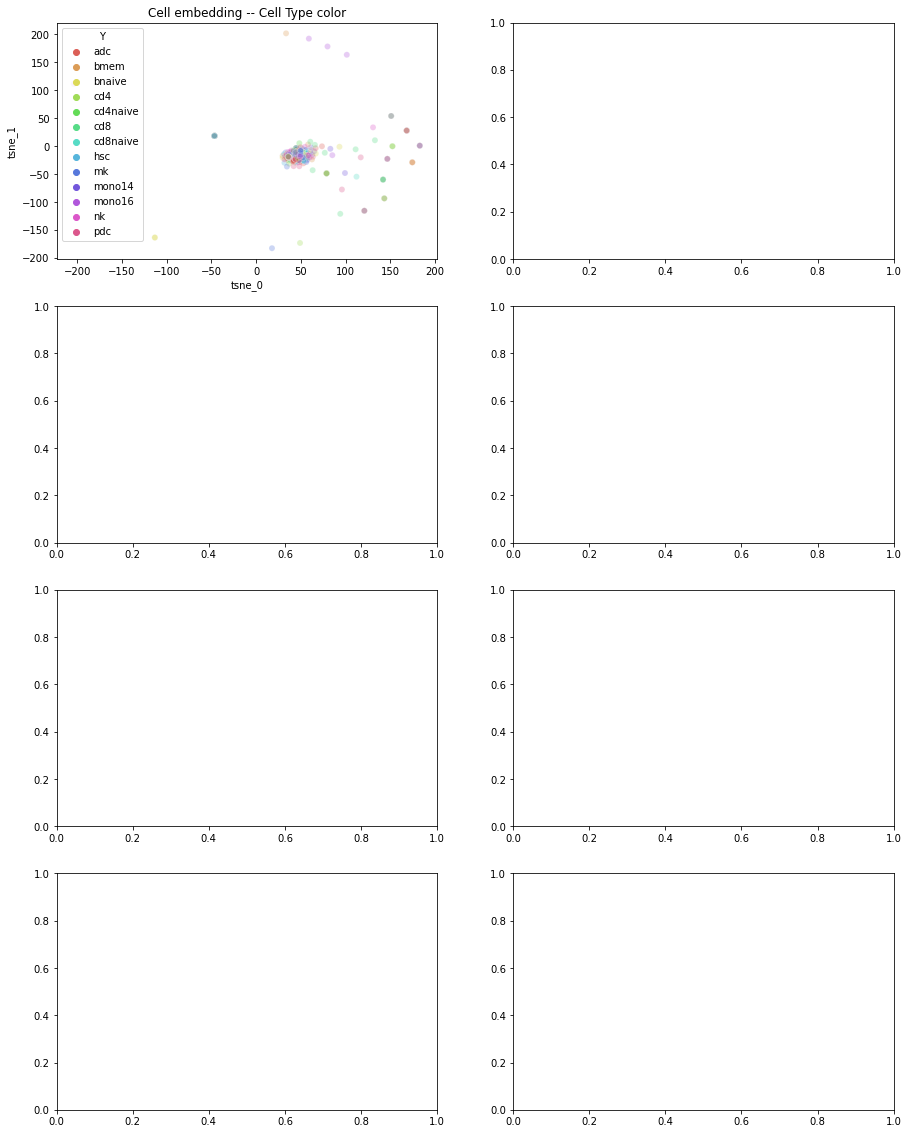

In [11]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# then plot on test data of sm2

X_temp = pbmc_rep2_10xV2_X.reindex(columns=pbmc68k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = scale(X_temp, axis=1)

Y_temp = pbmc_rep2_10xV2_Y.reindex(columns=pbmc_rep2_10xV2_Y.columns, fill_value=0)
Y_temp = pbmc_rep2_10xV2_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]

Label_full_sm2 = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                    np.full(n_train, 2), np.full(n_train, 3),
                    np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_temp = Label_full_sm2

print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc68k_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(4, 2, figsize=(15,20))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")


fig.suptitle("Test sm2 Data, Training on labeled: pbmc_rep2_10xV2 and unlabeled: pbmc_rep2_10xV2", fontsize=14)

fig.show()


Number unique Y: 5
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


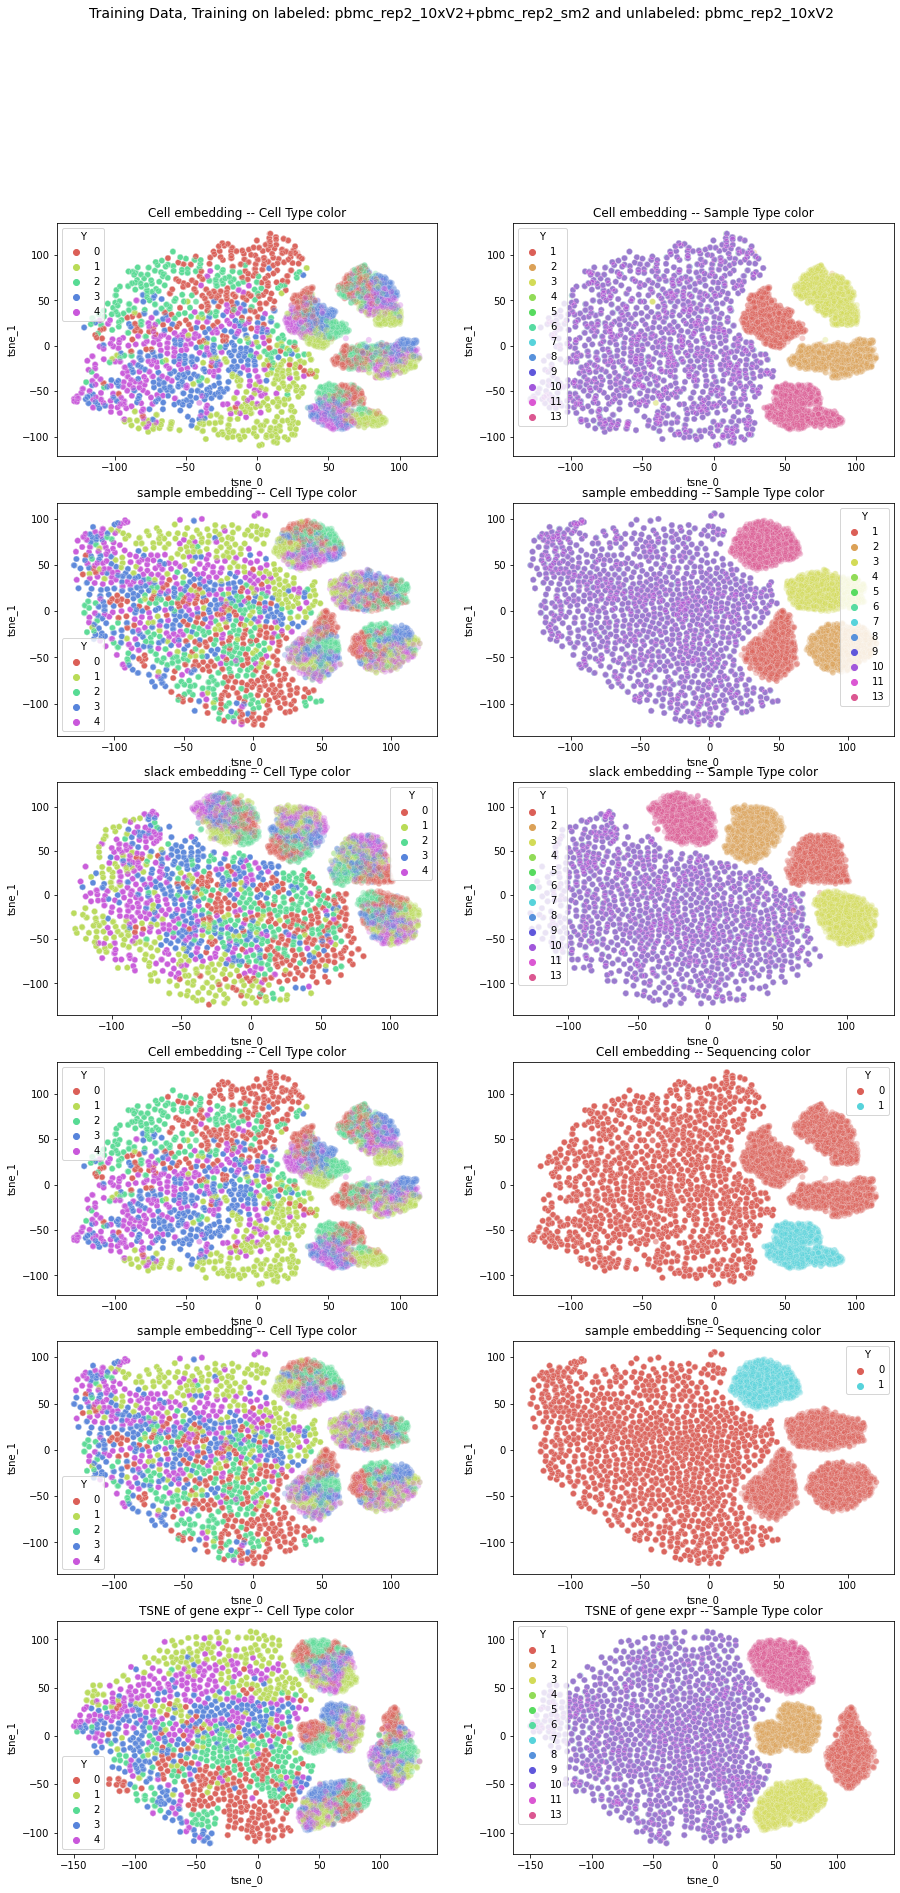

In [23]:
batch_size = 500
# NOW on the cross- trained model, plot the training data

Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9),
                            np.full(n_train, 10), np.full(n_train, 11)], axis=0)
Label_full_sm2 = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5)], axis=0)
Label_full = np.concatenate([Label_full, Label_full_sm2+12]) # +11
label_full = to_categorical(Label_full)

Label_seq = np.concatenate([np.full(n_train*12, 0), np.full(n_train*6, 1)], axis=0)



idx_train = np.where(np.logical_and(np.logical_and(Label_full >= 1, Label_full <= 13), Label_full != 12))[0]

X_temp = pbmc_rep2_10xV2_sm2_cells_X.reindex(columns=pbmc_rep2_sm2_train["gene_ids"], fill_value=0)
X_temp2 = pbmc_rep2_sm2_X.reindex(columns=pbmc_rep2_sm2_train["gene_ids"], fill_value=0)
X_temp = X_temp.to_numpy()
X_temp2 = X_temp2.to_numpy()
X_temp = np.concatenate((X_temp, X_temp2), axis=0)
X_temp = X_temp[idx_train,]        
X_temp = scale(X_temp, axis=1)


Y_temp = pbmc_rep2_10xV2_sm2_cells_Y.reindex(columns=pbmc_rep2_sm2_Y.columns, fill_value=0)
Y_temp2 = pbmc_rep2_sm2_Y.reindex(columns=pbmc_rep2_sm2_Y.columns, fill_value=0)
Y_temp = np.concatenate((Y_temp, Y_temp2), axis=0)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_train,]        

label_temp = Label_full[idx_train,]
Label_seq = Label_seq[idx_train,]

print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc_rep2_10xV2_sm2_cells_NONE_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(6, 2, figsize=(15,30))

plot_df_prop = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df_prop, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df_prop, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df_mu = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df_mu, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df_mu, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_tsne(plot_df_prop, color_vec=Y_temp, ax=axs[3,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df_prop, color_vec=Label_seq, ax=axs[3,1], title="Cell embedding -- Sequencing color")

plot_tsne(plot_df_mu, color_vec=Y_temp, ax=axs[4,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df_mu, color_vec=Label_seq, ax=axs[4,1], title="sample embedding -- Sequencing color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[5,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[5,1], title="TSNE of gene expr -- Sample Type color")


fig.suptitle("Training Data, Training on labeled: pbmc_rep2_10xV2+pbmc_rep2_sm2 and unlabeled: pbmc_rep2_10xV2", fontsize=14)

fig.show()


Number unique Y: 5
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)


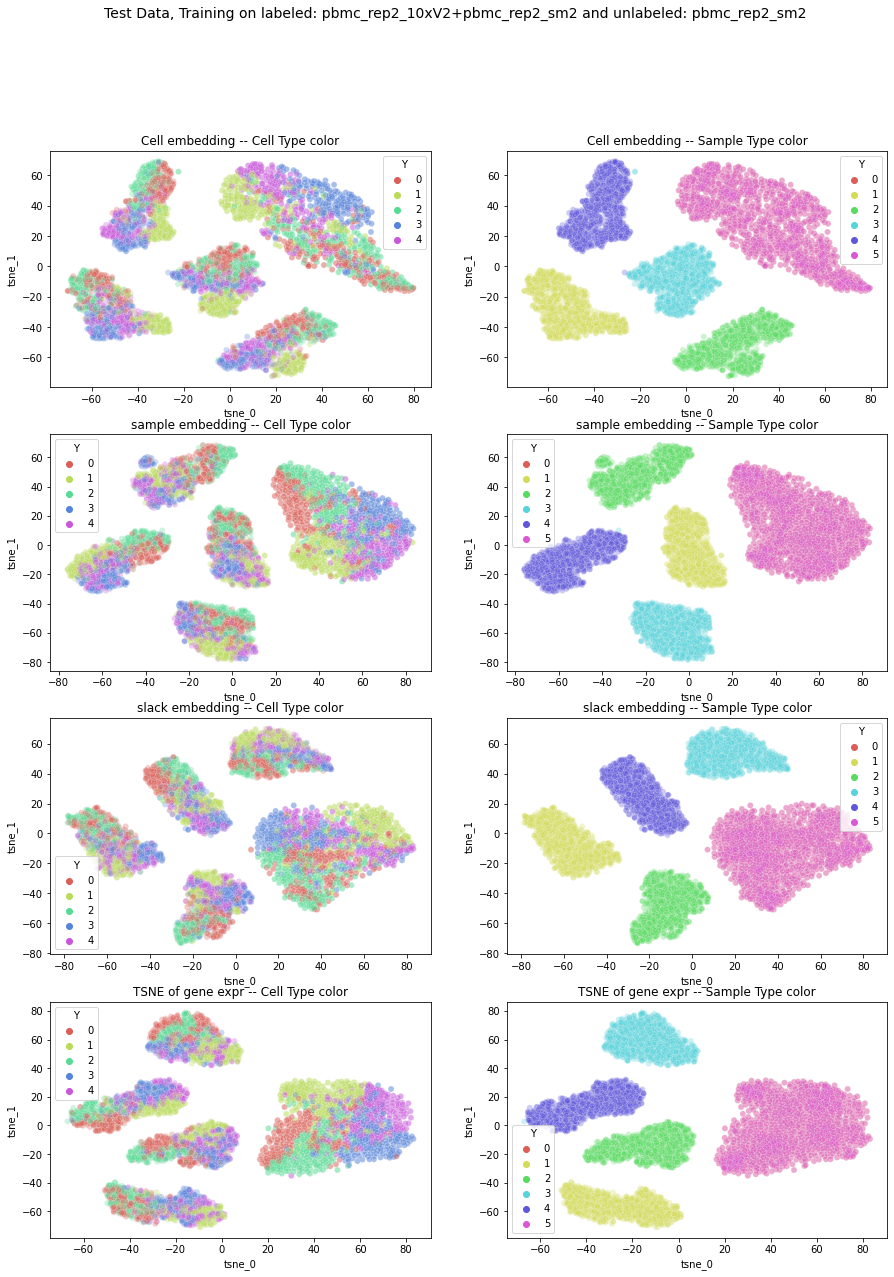

In [24]:
batch_size = 500
# NOW on the cross- trained model, plot the test data

X_temp = pbmc_rep1_sm2_X.reindex(columns=pbmc_rep2_sm2_train["gene_ids"], fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = scale(X_temp, axis=1)

Y_temp = pbmc_rep1_sm2_Y.reindex(columns=pbmc_rep2_sm2_Y.columns, fill_value=0)
Y_temp = np.argmax(Y_temp.to_numpy(), axis=1)

Label_full_sm2 = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                    np.full(n_train, 2), np.full(n_train, 3),
                    np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_temp = Label_full_sm2

print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc_rep2_10xV2_sm2_cells_NONE_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(4, 2, figsize=(15,20))

plot_df_prop = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df_prop, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df_prop, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df_mu = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df_mu, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df_mu, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")

fig.suptitle("Test Data, Training on labeled: pbmc_rep2_10xV2+pbmc_rep2_sm2 and unlabeled: pbmc_rep2_sm2", fontsize=14)

fig.show()


In [15]:

# import out preprocessing code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess
import evaluation_experiments.pbmc.pbmc_generate_data as gen_data

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from argparse import ArgumentParser
from importlib import reload
from functools import reduce

import pickle
import gzip
from pathlib import Path

def get_genes(GSE_data_path, exp_id, min_num_cells):

    # these are pre-defined parameters that are inherent
    # to each experiment
    pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc1', 
                        "num_cells":[253],
                        "file_id":'pbmc_rep1_sm2'})

    pbmc2_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[273],
                        "file_id":'pbmc_rep2_sm2'})

    pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a'})

    pbmc1_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a_sm2_cells'})

    pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2'})

    pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2_sm2_cells'})

    sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                    'CD16+ monocyte', 'B cell',
                    'CD4+ T cell', 'Megakaryocyte']

    #####################
    ### set the study ###
    #####################
    cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
    count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
    gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
    meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
    meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")


    if exp_id == "pbmc_rep1_sm2" :
        curr_study = pbmc1_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep2_sm2" :
        curr_study = pbmc2_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep1_10xV2a":
        curr_study = pbmc1_10x_param
    elif exp_id == "pbmc_rep1_10xV2a_sm2_cells":
        curr_study = pbmc1_10x_sm2_cells_param
    elif exp_id == "pbmc_rep2_10xV2":
        curr_study = pbmc2_10x_param
    elif exp_id == "pbmc_rep2_10xV2_sm2_cells":
        curr_study = pbmc2_10x_sm2_cells_param
    else:
        assert False, "Unrecognized experiment ID"


    # set the study specific parameters
    num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
    method_keep = curr_study["Method"].tolist()
    experiment_keep = curr_study["Experiment"].tolist()

    # read in the data
    cell_info, count_matr, gene_info, meta_info = gen_data.read_gse_input(cell_file, 
                                                                count_file, 
                                                                gene_file, 
                                                                meta_file, 
                                                                meta_tsne_file)

    # format the data
    pbmc1_a_dense = gen_data.format_cell_reads_info(meta_info, cell_info, count_matr, 
                                                    num_cells_expected, method_keep, 
                                                    experiment_keep)

    # get the gene names that pass
    pbmc1_a_expr, gene_pass = gen_data.filter_by_expr(pbmc1_a_dense, -1, gene_info)

    # get cell type info
    pbmc1_a_df, _ = gen_data.join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass)

    # filter to sm2 cell types if needed
    if exp_id == "pbmc_rep1_10xV2a_sm2_cells" or exp_id == "pbmc_rep2_10xV2_sm2_cells":
        pbmc1_a_df = pbmc1_a_df[pbmc1_a_df['CellType'].isin(sm2_cell_types)]


    # get the gene names that pass
    pbmc1_a_df_num = pbmc1_a_df.drop("CellType", axis=1)
    pbmc1_a_df_num = pbmc1_a_df_num.transpose()
    pbmc1_a_binary = np.where(pbmc1_a_df_num>0,1,0)
    pbmc1_a_df_num = pbmc1_a_df_num[pbmc1_a_binary.sum(axis=1) > min_num_cells]

    # return the numeric df as well
    col_idx = pd.Index(['CellType'])
    col_idx = col_idx.append(pbmc1_a_df_num.index)

    return pbmc1_a_df_num.index, pbmc1_a_df[col_idx]

def get_variable_genes(inter_genes, num_genes, expr_df, cell_types):


    union_genes = []
    for cell_type in cell_types:

        cell_type_expr = expr_df.loc[expr_df['CellType'] == cell_type]
        cell_type_expr = cell_type_expr[inter_genes]
        cell_type_expr = cell_type_expr.to_numpy()

        X_colmean = cell_type_expr.mean(axis=0)
        X_colvar = cell_type_expr.var(axis=0)
        X_CoV = np.array(np.divide(X_colvar, X_colmean))
        idx_top = np.argpartition(X_colmean, -num_genes)[-num_genes:]
        cell_type_expr = cell_type_expr[:,idx_top]
        index_res = inter_genes[idx_top]
        index_res = index_res.tolist()
        union_genes.append(index_res)

    union_genes = reduce(np.union1d, union_genes)

    return(union_genes)


In [16]:
GSE_data_path=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/"
aug_data_path=f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

min_num_cells = 1
all_ids = ['pbmc_rep1_sm2', 'pbmc_rep2_10xV2_sm2_cells', "pbmc_rep1_10xV2a_sm2_cells"]

inter_genes = []
expr_df_list = [] 
for exp_id in all_ids:
    index_res, expr_df = get_genes(GSE_data_path, exp_id, min_num_cells)
    index_res = index_res.tolist()
    inter_genes.append(index_res)
    expr_df_list.append(expr_df)

inter_genes = reduce(np.intersect1d, inter_genes)


Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)


In [27]:

cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                'CD16+ monocyte', 'B cell',
                'CD4+ T cell', 'Megakaryocyte']

num_genes = 1700
var_genes = []
curr_idx = 0
for exp_id in all_ids:
    curr_expr_df = expr_df_list[curr_idx]

    col_idx = pd.Index(['CellType'])
    col_idx = col_idx.append(pd.Index(inter_genes))
    curr_expr_df = curr_expr_df[col_idx]

    index_res = get_variable_genes(inter_genes, num_genes, curr_expr_df, cell_types)

    var_genes.append(index_res)
    print(index_res.shape)


    curr_idx = curr_idx+1

var_genes_final = reduce(np.union1d, var_genes)

print(var_genes_final.shape)


/tmp/ipykernel_318128/146223926.py:143: RuntimeWarning: invalid value encountered in true_divide
  X_CoV = np.array(np.divide(X_colvar, X_colmean))


(6880,)
(6242,)
(6180,)
(10649,)


In [28]:
propr_file = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/pbmc_rep1_sm2_pseudo_0.pkl"
gene_df_train = pickle.load( open( propr_file, "rb" ) )
gene_df_train

gene_ids,ENSG00000000003_TSPAN6,ENSG00000000005_TNMD,ENSG00000000419_DPM1,ENSG00000000457_SCYL3,ENSG00000000460_C1orf112,ENSG00000000938_FGR,ENSG00000000971_CFH,ENSG00000001036_FUCA2,ENSG00000001084_GCLC,ENSG00000001167_NFYA,...,ENSG00000283051_KB-51A8.1,ENSG00000283052_RP11-210L7.3,ENSG00000283058_RP11-358H12.1,ENSG00000283061_ABC7-481722F1.2,ENSG00000283064_RP1-221C16.8,ENSG00000283095_ABC11-4932300O16.1,ENSG00000283103_LLNLR-245B6.1,ENSG00000283117_CTD-2060L22.1,ENSG00000283118_RP11-107E5.4,ENSG00000283125_RP11-299P2.2
0,12678.237614,1813.795464,2231.553802,937.117800,8212.637639,14035.522338,41487.639621,3142.607234,3597.668841,2527.583159,...,2113.612327,1047.051240,2577.745494,9245.797695,1034.663788,845.427453,6458.569014,1010.674337,4418.287828,4232.027514
0,4954.357970,1976.785115,1090.200953,415.091966,3412.492026,5524.675365,8635.386455,1493.369958,1454.779657,1679.275278,...,700.611420,806.013430,791.092366,992.434760,346.024511,1070.482199,6242.297479,743.491605,2387.639534,2451.047772
0,21826.962663,2367.154245,7092.076597,1896.433188,8000.288398,4891.460200,17882.855954,4764.296998,7514.713717,5329.768642,...,1032.009626,1540.337320,4600.386461,7344.866629,861.841935,1637.655545,13333.477739,660.803437,4037.254475,4565.784525
0,7755.216289,820.158393,1477.170532,396.632776,4314.198374,2117.812291,14192.716342,1545.518754,2583.571108,2495.200523,...,471.559200,414.291648,1805.190479,1405.589090,438.065005,635.677874,4703.189484,365.931905,1539.389159,1203.399123
0,21273.670765,1892.091509,3118.227817,1147.489188,12870.797903,17554.914609,26389.604215,6269.530949,11549.040118,4340.859760,...,1928.255817,1816.202131,4563.816913,5016.128865,1352.287823,1661.939627,12444.121190,586.176744,3586.454418,4306.485025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,17261.471946,4557.371331,3264.925721,1842.400779,11346.858168,3824.410718,38466.413512,7654.056819,14333.671339,4050.278584,...,1512.136221,2269.821145,4042.135779,6039.128563,585.573640,2652.184725,23291.411517,1021.466964,6898.320188,2709.891380
0,14958.581871,1672.199641,1835.682016,1022.501913,10054.588567,6530.978514,10677.769273,2617.605807,4936.414377,3510.527058,...,1168.107255,1189.510475,2529.815797,3192.095047,632.232644,941.076066,7698.261041,878.603279,2050.064723,1621.296593
0,13301.658521,1400.650450,3248.119925,808.328434,6816.878478,3755.638044,12737.256079,1872.995381,4187.190672,7612.187819,...,1380.598385,2188.467973,1144.311688,3951.870451,1114.470426,847.420191,9658.740583,718.743225,4986.067240,1878.933746
0,17881.698602,1079.235488,3202.934429,1001.636914,6906.764155,1684.987101,20477.818021,1726.524046,4522.227686,4122.379780,...,2407.321425,772.115088,2596.244995,4648.162160,278.246682,813.932367,19879.891115,650.254854,1850.096294,3135.207724


In [29]:
propr_file = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data_nocellfilter/pbmc_rep1_sm2_pseudo_0.pkl"
gene_df_train = pickle.load( open( propr_file, "rb" ) )
gene_df_train

gene_ids,ENSG00000000003_TSPAN6,ENSG00000000005_TNMD,ENSG00000000419_DPM1,ENSG00000000457_SCYL3,ENSG00000000460_C1orf112,ENSG00000000938_FGR,ENSG00000000971_CFH,ENSG00000001036_FUCA2,ENSG00000001084_GCLC,ENSG00000001167_NFYA,...,ENSG00000283051_KB-51A8.1,ENSG00000283052_RP11-210L7.3,ENSG00000283058_RP11-358H12.1,ENSG00000283061_ABC7-481722F1.2,ENSG00000283064_RP1-221C16.8,ENSG00000283095_ABC11-4932300O16.1,ENSG00000283103_LLNLR-245B6.1,ENSG00000283117_CTD-2060L22.1,ENSG00000283118_RP11-107E5.4,ENSG00000283125_RP11-299P2.2
0,42.451095,0.000000,4393.514751,4.217069,240905.958541,26232.377841,11901.381305,9215.253746,1237.511869,4488.009156,...,0.000000,0.000000,0.000000,7.930728,5.820321,1.220704,2816.316423,390.660841,623.586303,28.621008
0,300.133858,4543.828760,24544.351987,15.027339,30436.303926,180376.527330,155035.361559,25507.206600,14252.879090,27525.385545,...,719.813023,18.025524,0.000000,7.716965,70.934830,16.220763,6559.114871,1563.799106,10574.354693,152.130426
0,2141.848111,5649.036537,19466.568837,47.690640,7423.381328,4391.972772,357789.964584,49430.582557,16611.254318,4172.211217,...,750.542555,98.823414,58.218754,2.502557,76.955869,22.806112,16927.796330,2758.235069,3704.049206,1289.530117
0,305.978042,0.000000,41944.510816,720.679422,637.326691,21175.443258,4200.494663,2466.413971,7783.399291,14779.845727,...,0.000000,384.086467,1311.712510,0.000000,47.638442,5.292468,2067.441222,1344.017687,732.956372,0.000000
0,15.421228,0.000000,8900.325929,55.676653,7286.792202,17160.088706,3823.738187,10140.745425,1883.336915,2949.555512,...,0.000000,0.000000,66.996618,1.564951,0.888755,0.215875,1922.946390,232.563514,285.764198,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,43.247931,0.000000,85079.837576,94.567299,71576.203393,153078.335778,1160.189989,64741.612973,37463.886435,69331.362585,...,0.000000,0.000000,5.711355,122.649719,35.287175,17.757041,23185.521967,1595.552116,8014.234082,0.000000
0,57.430199,203.756363,27855.181925,83.107389,15256.338533,192287.620713,14093.028054,92047.813047,22651.913018,49927.706537,...,0.000000,37.305504,134.151846,123.769132,88.406617,12.209415,6663.662777,1658.137116,6697.903445,8.396665
0,496.235315,1821.497329,9638.146618,8.506041,8041.798378,8584.803337,24428.559998,7996.458947,3713.803089,2023.083086,...,103.336855,0.000000,136.350954,0.000000,14.678656,13.479775,3353.093833,1012.030889,535.573694,75.365203
0,75.163778,176.448982,15504.071541,64.795609,56133.949328,80685.094358,2110.160599,18296.184134,11569.649271,39152.613906,...,16.982024,0.000000,8.769901,3.189170,13.191470,2.585244,5352.981750,792.396598,14202.976471,7.483482


In [30]:
cell_type_id = 'B cell'
expr_df = expr_df_list[0]

# get the expression of the cells of interest
cell_df = expr_df[expr_df.CellType.isin([cell_type_id])]
cell_sample = cell_df[inter_genes[range(5)]]

# now to the sampling
cell_sample = cell_sample.sample(n=10, replace=True)

# add  poisson noise
noise_mask = np.random.poisson(cell_sample+1)
cell_sample_noise = cell_sample + noise_mask



In [31]:
cell_sample.sum(axis=0)

ENSG00000000003_TSPAN6        0.0
ENSG00000000419_DPM1          0.0
ENSG00000000457_SCYL3         0.0
ENSG00000000460_C1orf112    366.0
ENSG00000000938_FGR           2.0
dtype: float64

In [32]:
cell_sample_noise.sum(axis=0)

ENSG00000000003_TSPAN6        6.0
ENSG00000000419_DPM1         11.0
ENSG00000000457_SCYL3        11.0
ENSG00000000460_C1orf112    735.0
ENSG00000000938_FGR          15.0
dtype: float64

In [35]:
n_train = 2
### create the domains label 
Label_full = np.concatenate([np.full(n_train, idx) for idx in range(10)], axis=0)
label_full = to_categorical(Label_full)
label_full

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)